In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
import functools
import os
import random
import re
import enum
import time
from datetime import datetime, timedelta
from typing import Protocol, TypedDict
from zoneinfo import ZoneInfo

import dotenv
import finnhub
import matplotlib.pyplot as plt
import numpy as np
import torch
import yfinance as yf
from langchain_ollama import OllamaLLM
from scipy import stats
from sklearn.linear_model import LinearRegression
from transformers import AutoTokenizer, pipeline

# Load API Keys

In [24]:
dotenv.load_dotenv()

FINNHUB_API_KEY = os.getenv('FINNHUB_API_KEY')

In [25]:
finnhub_client = finnhub.Client(api_key=FINNHUB_API_KEY)

In [26]:
def ticker_closing_timeseries_data(ticker: yf.Ticker, start: str, end: str) -> tuple[list[datetime], list[float]]:
    '''
    ticker: yf.Ticker for a particular company/index.
    start: Start date YYYY-MM-DD
    end: End date YYYY-MM-DD

    Returns: A list of all trading days represented by datetime, and a list of floats for corresponding closing prices.
    '''
    history = ticker.history(interval='1d', start=start, end=end)
    series = history['Close']
    return (
        [datetime(timestamp.year, timestamp.month, timestamp.day, hour=16, tzinfo=ZoneInfo('America/New_York')) for timestamp in series.index], 
        list(series),
    )

ticker_closing_timeseries_data(yf.Ticker('^DJI'), '2024-10-01', '2024-10-07')

([datetime.datetime(2024, 10, 1, 16, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')),
  datetime.datetime(2024, 10, 2, 16, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')),
  datetime.datetime(2024, 10, 3, 16, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York')),
  datetime.datetime(2024, 10, 4, 16, 0, tzinfo=zoneinfo.ZoneInfo(key='America/New_York'))],
 [42156.96875, 42196.51953125, 42011.58984375, 42352.75])

In [27]:
class FinnhubArticle(TypedDict):
    category: str
    datetime: int
    headline: str
    id: int
    image: str
    related: str
    source: str
    summary: str
    url: str


@functools.cache
def finnhub_cache_company_news(symbol: str, _from: str, to: str) -> list[FinnhubArticle]:
    return finnhub_client.company_news(symbol, _from, to)


def fetch_finnhub_articles(symbols: list[str], start: str, end: str) -> list[FinnhubArticle]:
    '''
    symbols: list of stock ticker symbols
    start: Start date YYYY-MM-DD
    end: End date YYYY-MM-DD

    Return: Uses finnhub api and gets a list of FinnhubArticle about the given stocks from start to end date.
    '''
    articles = []

    current_date = start_date = datetime.strptime(start, '%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')

    while current_date < end_date:
        for symbol in symbols:

            while True:
                try:
                    fetched = finnhub_cache_company_news(
                        symbol, 
                        _from=current_date.strftime('%Y-%m-%d'),
                        to=(current_date + timedelta(days=1)).strftime('%Y-%m-%d'),
                    )
                except finnhub.FinnhubAPIException:
                    continue

                articles += fetched
                break

        current_date += timedelta(days=1)
        print(f'Fetched {len(articles)} articles', end='\r')

    #for symbol in symbols:
    #    articles += finnhub_client.company_news(symbol, _from=start, to=end)

    return articles


def group_by_day_finnhub_articles(articles: list[FinnhubArticle], time_buckets: list[datetime]) -> list[list[FinnhubArticle]]:
    '''
    Group list of FinnhubArticles into time buckets. An article is considered to be
    in a given datetime bucket if it was published between the given datetime and the 
    previous datetime (the previous trading day). If there is no previous datetime
    given, use the current datetime minus one day.

    articles: list of FinnhubArticle objects to be grouped.
    time_buckets: list of python datetime objects representing

    Return: list with same length as time_buckets, with FinnhubArticle objects grouped.
    '''
    assert time_buckets == sorted(time_buckets), 'time_buckets should be sorted'
    grouped = []

    for i, current_datetime in enumerate(time_buckets):
        if i == 0:
            previous_datetime = current_datetime - timedelta(days=1)
        else:
            previous_datetime = time_buckets[i-1]

        current_bucket = []
        
        for article in articles:
            if previous_datetime <= datetime.utcfromtimestamp(article['datetime']).replace(tzinfo=ZoneInfo('UTC')) < current_datetime:
                current_bucket.append(article)

        grouped.append(current_bucket)

    return grouped


def process_finnhub_article(article: FinnhubArticle) -> str:
    '''Turn FinnhubArticle object into a string that can be passed into a sentiment analyser.'''
    template = '{headline}: {content}'
    return template.format(headline=article['headline'], content=article['summary'])   

In [28]:
class SentimentAnalyzer(Protocol):

    def __call__(self, inputs: list[str]) -> list[float]:
        '''
        inputs: List of strings that are preprocessed news articles.
        
        Return: List of floats ranging from [-1.0, 1.0], representing sentiment for each news article.
        '''
        pass


class DistilRobertaSentimentAnalyzer:

    def __init__(self) -> None:
        self.model = 'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'
        self.pipe = pipeline('text-classification', 
                             model=self.model, 
                             device='cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(self.model)

    def __call__(self, inputs: list[str]) -> list[float]:
        truncated_inputs = []
        max_length = self.tokenizer.model_max_length

        # Truncate to text to fit within max_length
        for text in inputs:
            # Tokenize the input text
            tokens = self.tokenizer(text, truncation=True, max_length=max_length, return_tensors='pt')
            truncated_inputs.append(self.tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=True))

        # Pass in all inputs in a batch to the language model for efficiency.
        raw_outputs = self.pipe(truncated_inputs, top_k=None)

        outputs = []

        for raw_output in raw_outputs:
            score = 0
            
            for d in raw_output:
                if d['label'] == 'positive':
                    score += d['score']
                elif d['label'] == 'negative':
                    score -= d['score']
                
            # Clamp score between -1.0 and 1.0 in case of floating point errors.
            score = max(-1.0, min(1.0, score))

            outputs.append(score)
        
        return outputs


class OllamaSentimentAnalyzer:

    def __init__(self, temperature: float = 0.0, verbose: bool = False) -> None:
        self.model = OllamaLLM(model='llama3.2', temperature=temperature)
        self.ask_sentiment_prompt = '''
            TASK: Do sentiment analysis on financial article.
        
            ARTICLE: {text}

            :ARTICLE END:
            
            Give a sentiment score from [-1.0 to 1.0]. Just give the number. No words.
        '''
        
    def __call__(self, inputs: list[str]) -> list[float]:
        # Prompts asking for a description of the sentiment.
        inputs = [self.ask_sentiment_prompt.format(text=text) for text in inputs]

        raw_scores = self.model.batch(inputs=inputs)
        
        outputs = []
        
        for raw_score in raw_scores:
            # Look for a float number in each response.
            match = re.search(r'-?\d+(\.\d+)?', raw_score)
            score = float(match.group() if match else 0.0)

            outputs.append(score)
        
        return outputs


def finnhub_articles_mean_sentiment(articles: list[FinnhubArticle], sentiment_analyzer: SentimentAnalyzer, sample_size: int = -1) -> float:
    '''
    articles: List of FinnhubArticle objects.
    sentiment_analyzer: What sentiment analyzer to use.
    sample_size: Take mean sentiment of a random sample. 
                 If sample_size = -1 (default value), take the mean of all samples.

    returns: Sentiment score between -1 and 1
    '''
    if sample_size >= 0:
        articles = random.sample(articles, min(sample_size, len(articles)))
    
    # Neutral sentiment if no articles.
    if not articles:
        print('yoho')
        return 0.0

    sentiment_scores = sentiment_analyzer([process_finnhub_article(article) for article in articles])

    return np.mean(sentiment_scores)

# Putting it all together

In [29]:
def test(
    company_symbols: list[str],
    ticker: yf.Ticker,
    start: str,
    end: str,
    sentiment_analyzer: SentimentAnalyzer,
) -> None:
    '''
    company_symbols: symbols for all companies that we want to pull news for.
    ticker: yf.Ticker for index/company share price we want to track
    start: Start date YYYY-MM-DD
    end: End date YYYY-MM-DD
    '''

    dates, closing_prices = ticker_closing_timeseries_data(ticker, start, end)

    articles = fetch_finnhub_articles(company_symbols, start, end)
    print(f'Fetched {len(articles)} articles...\n')

    grouped_articles = group_by_day_finnhub_articles(articles, dates)

    mean_daily_sentiment_scores = []
    for date, group in zip(dates, grouped_articles):
        print('Computing sentiment scores for', date.strftime('%Y-%m-%d'), end='\r')
        mean_daily_sentiment_scores.append(finnhub_articles_mean_sentiment(group, sentiment_analyzer))

    print('Finished computing all daily news mean sentiment scores.\n')

    difference = np.diff(closing_prices)

    # Calculate actual price movement 
    # (True if price increase, False if price stayed the same or decreased)
    price_movement = difference > 0  

    # Predict price movement based on sentiment
    sentiment_predictions = np.array(mean_daily_sentiment_scores[1:]) >= 0

    true_positives = np.sum(sentiment_predictions & price_movement)
    false_positives = np.sum(sentiment_predictions & ~price_movement)
    false_negatives = np.sum(~sentiment_predictions & price_movement)

    # Compute accuracy
    correct_predictions = np.sum(sentiment_predictions == price_movement)
    total_predictions = len(price_movement)
    
    accuracy = correct_predictions / total_predictions
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)

    # Plot price difference and sentiment.
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price Difference (USD)', color='tab:blue')
    ax1.plot(dates[1:], difference, color='tab:blue', label='Price Difference')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Sentiment', color='tab:red')
    ax2.plot(dates[1:], mean_daily_sentiment_scores[1:], color='tab:red', label='Sentiment', linestyle='dashed')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    plt.title('Price Difference and Sentiment Over Time')
    fig.tight_layout()
    plt.grid()

    # Do linear regression for sentiment scores and price difference.
    model = LinearRegression()
    model.fit(np.array(mean_daily_sentiment_scores[1:]).reshape(-1, 1), difference)
    
    slope = model.coef_[0]
    intercept = model.intercept_
    
    price_diff_pred = model.predict(np.array(mean_daily_sentiment_scores[1:]).reshape(-1, 1))
    r_squared = model.score(np.array(mean_daily_sentiment_scores[1:]).reshape(-1, 1), difference)

    correlation, p_value = stats.pearsonr(mean_daily_sentiment_scores[1:], difference)

    plt.figure(figsize=(10, 6))

    plt.scatter(mean_daily_sentiment_scores[1:], difference, color='blue', label='Actual Data')
    # Plot regression line.
    plt.plot(np.array(mean_daily_sentiment_scores[1:]).reshape(-1, 1), price_diff_pred, color='red', label='Fitted Line')
    
    plt.xlabel('Sentiment')
    plt.ylabel('Price Difference (USD)')
    plt.title('Linear Fit of Sentiment vs Price Difference')

    plt.grid(True)
    plt.show()

    print(f"Slope of the fitted line: {slope:.4f}")
    print(f"Intercept of the fitted line: {intercept:.4f}")
    print(f"R^2 (Coefficient of Determination): {r_squared:.4f}")
    print(f"Correlation: {correlation:.4f}")
    print(f"P-value: {p_value:.4e}")

# Create sentiment analyzer

In [30]:
sentiment_analyzer = DistilRobertaSentimentAnalyzer()

# Run for single stock (AAPL)

Fetched 7230 articles...

Finished computing all daily news mean sentiment scores.

Accuracy:  0.6190476190476191
Precision:  0.6428571428571429
Recall:  0.9


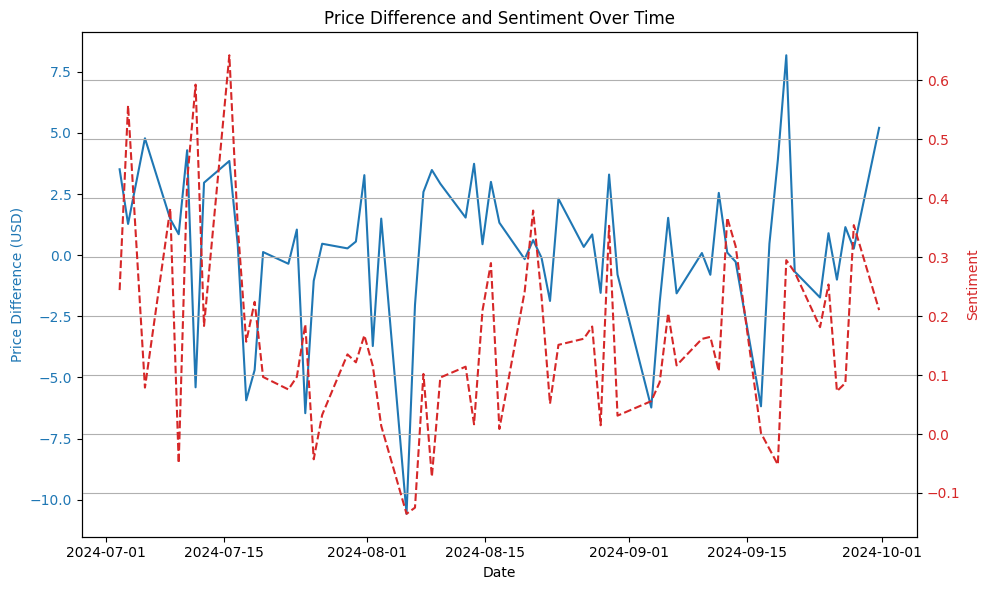

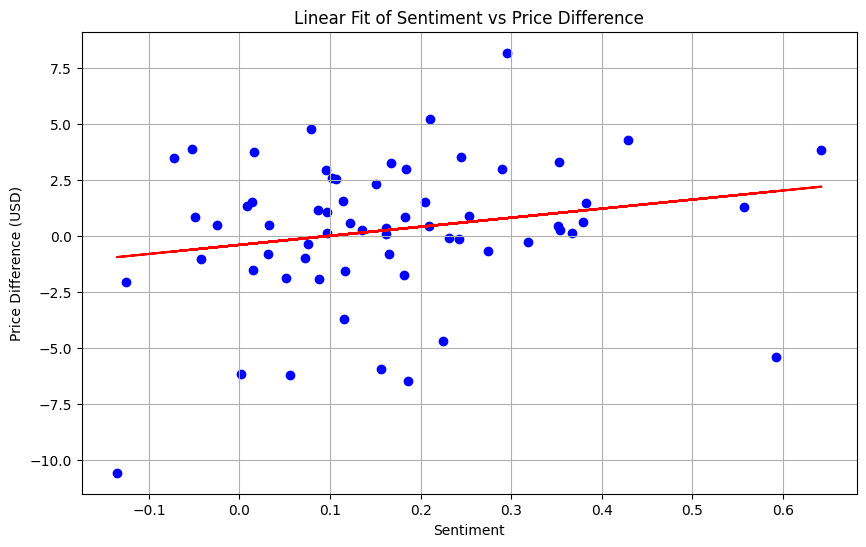

Slope of the fitted line: 4.0465
Intercept of the fitted line: -0.4016
R^2 (Coefficient of Determination): 0.0417
Correlation: 0.2042
P-value: 1.0845e-01


In [31]:
test(['AAPL'], yf.Ticker('AAPL'), '2024-07-01', '2024-10-01', sentiment_analyzer)

# Run for an industry (SOXX)

Fetched 24383 articles...

Finished computing all daily news mean sentiment scores.

Accuracy:  0.6031746031746031
Precision:  0.5740740740740741
Recall:  0.9393939393939394


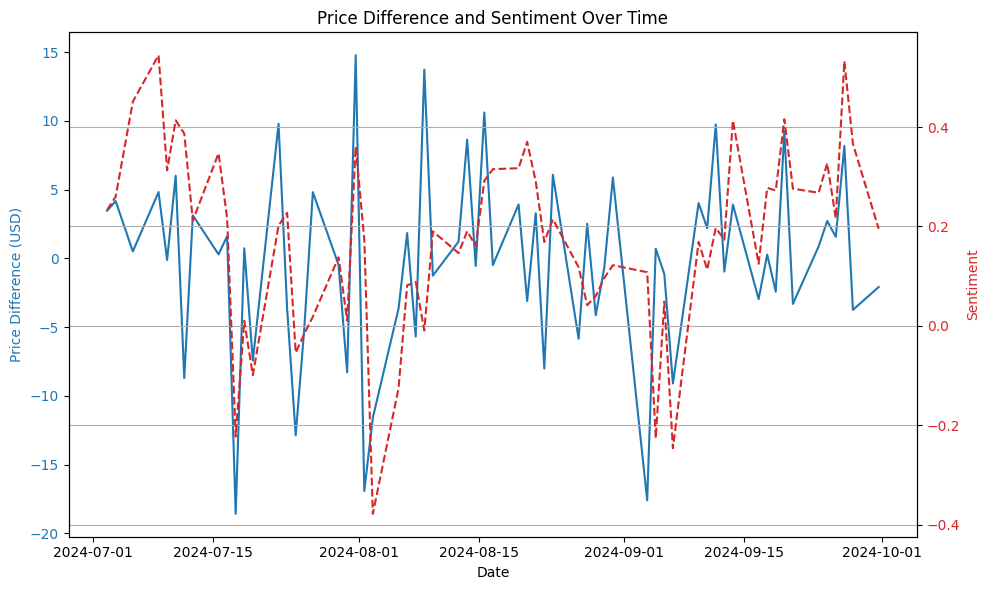

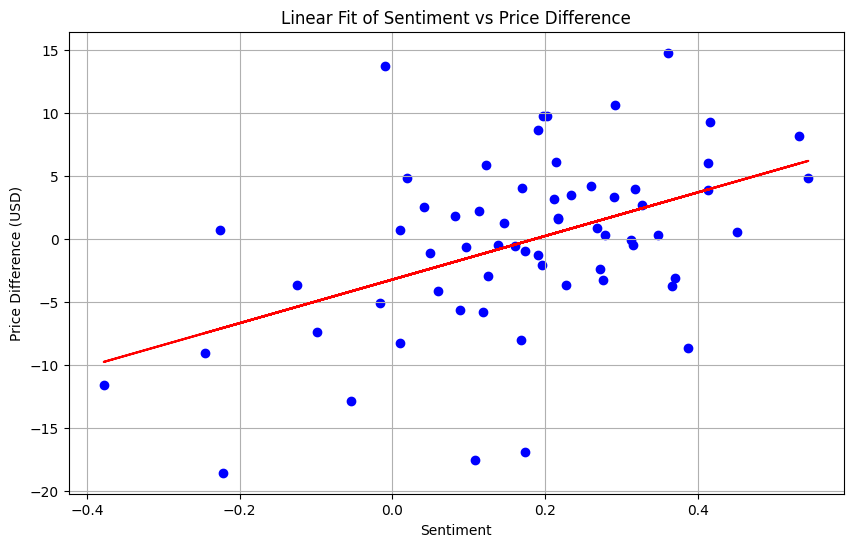

Slope of the fitted line: 17.2999
Intercept of the fitted line: -3.2394
R^2 (Coefficient of Determination): 0.2121
Correlation: 0.4605
P-value: 1.4608e-04


In [32]:
# Top 10 holdings for SOXX (semiconductor industry)
SOXX_TOP10 = ['AMD', 'AVGO', 'NVDA', 'QCOM', 'TXN', 'MU', 'AMAT', 'INTC', 'MPWR', 'LRCX']

test(SOXX_TOP10, yf.Ticker('SOXX'), '2024-07-01', '2024-10-01', sentiment_analyzer)

# Use Dow30 to gauge recession sentiment and general market health

Fetched 59961 articles...

Finished computing all daily news mean sentiment scores.

Accuracy:  0.6349206349206349
Precision:  0.6440677966101694
Recall:  0.95


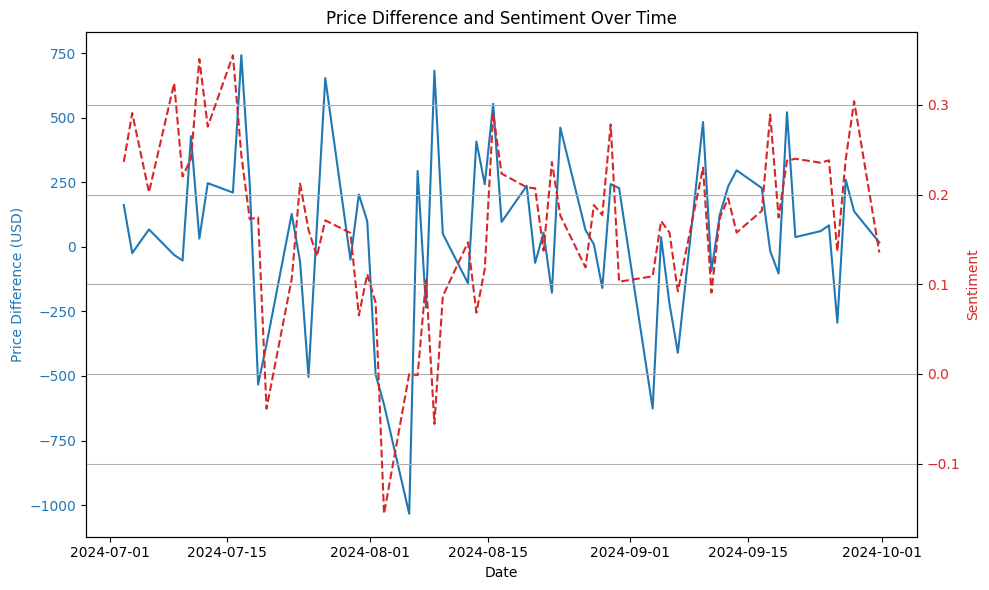

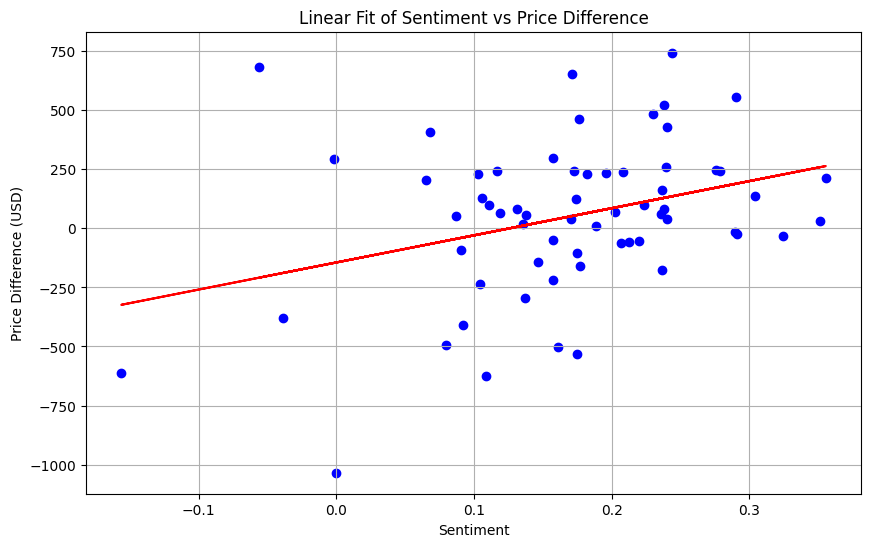

Slope of the fitted line: 1147.6438
Intercept of the fitted line: -144.5687
R^2 (Coefficient of Determination): 0.1109
Correlation: 0.3330
P-value: 7.6557e-03


In [34]:
DOW30 = [
    'MMM', 'AXP', 'AMGN', 'AMZN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'DOW', 'GS', 'HD', 'HON',
    'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WMT',
]

test(DOW30, yf.Ticker('^DJI'), '2024-07-01', '2024-10-01', sentiment_analyzer)